# GPT-2 Fruit Representation PCA

Let's look at the representations induced in a wine after being described by various fruits. 

In [2]:
# Imports 
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

from sklearn.decomposition import PCA

## Load GPT-2 


In [25]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to('cuda')

if hasattr(tokenizer, 'padding_side'):
    tokenizer.padding_side = 'left'



In [26]:
# Sanity check: What is the model loss on this sample input sentence? 
input_str = "The wine had notes of lemon. Therefore, the wine" 
input_ids = tokenizer.encode(input_str, return_tensors="pt").to('cuda')

# Generate the output
output = model(input_ids, labels=input_ids)
loss = output.loss
print("Loss: ", loss.item())

Loss:  4.858684062957764


## Load Webster's Dictionary

We are going to pull the [Webster's Unabridged Dictionary](https://www.gutenberg.org/ebooks/29765)
from project Gutenberg and parse it to find adjectives. 

In [27]:
fruits = [
    "Apple",
    "Banana",
    "Orange",
    "Mango",
    "Strawberry",
    "Pineapple",
    "Papaya",
    "Watermelon",
    "Cantaloupe",
    "Honeydew Melon",
    "Grape",
    "Blueberry",
    "Raspberry",
    "Blackberry",
    "Cherry",
    "Peach",
    "Plum",
    "Nectarine",
    "Kiwi",
    "Passion Fruit",
    "Dragon Fruit",
    "Star Fruit",
    "Avocado",
    "Pomegranate",
    "Fig",
    "Guava",
    "Lychee",
    "Kumquat",
    "Persimmon",
    "Tamarind",
    "Jackfruit",
    "Durian",
    "Date",
    "Apricot",
    "Coconut",
    "Lime",
    "Lemon",
    "Grapefruit",
    "Tangerine",
    "Clementine",
    "Mandarin Orange",
    "Blood Orange",
    "Pear",
    "Quince",
    "Loquat",
    "Mamey Sapote",
    "Sapodilla",
    "Cherimoya",
    "Soursop",
    "Ugli Fruit",
    "Mulberry",
    "Gooseberry",
    "Elderberry",
    "Cranberry",
    "Red Currant",
    "Black Currant",
    "White Currant",
    "Boysenberry",
    "Loganberry",
    "Cloudberry",
    "Feijoa",
    "Acai Berry",
    "Jujube",
    "Pomegranate",
    "Rambutan",
    "Mangosteen",
    "Salak",
    "Longan",
    "Snake Fruit",
    "Pawpaw",
    "Prickly Pear",
    "Physalis",
    "Sea Buckthorn",
    "Miracle Fruit",
    "Monstera Deliciosa Fruit",
    "Horned Melon",
    "Kiwano",
    "Pepino Melon",
    "Canary Melon",
    "Charentais Melon",
    "Santa Claus Melon",
    "Galia Melon",
    "Sharlyn Melon",
    "Crenshaw Melon",
    "Bitter Melon",
    "Cassava Melon",
    "Winter Melon",
    "Sponge Gourd",
    "Rose Apple",
    "Sugar Apple",
    "Velvet Apple",
    "Malay Apple",
    "Custard Apple",
    "Sweet Lime",
    "Sweet Lemon",
    "Buddha's Hand",
    "Yuzu",
    "Sudachi",
    "Kabosu",
    "Bergamot Orange"
  ]

In [ ]:
fruits = [
    "blackberry",
    "strawberry",
    "raspberry",
    "blueberry",
    "cherry",
    "plum",
    "apple",
    "pear",
    "peach",
    "apricot",
    "nectarine",
    "lemon",
    "lime",
    "grapefruit",
    "orange",
    "tangerine",
    "mandarin",
    "kumquat",
    "pomegranate",
    "fig",
    "date",
    "grape",
    "melon",
    "watermelon",
    "cantaloupe",
    "honeydew",
    "kiwi",
    "pineapple",
    "mango",
    "papaya",
    "banana",
    "coconut",
    "passion fruit",
    "guava",
    "lychee",
    "star fruit",
    "dragon fruit",
    "jackfruit",
    "durian",
    "persimmon",
    "quince",
    "currant",
    "gooseberry",
    "elderberry",
    "cranberry",
    "loganberry",
    "mulberry",
    "boysenberry",
    "blackcurrant",
    "red currant",
    "white currant",
    "dewberry",
    "cloudberry",
    "rowanberry",
    "huckleberry",
    "bilberry",
    "lingonberry",
    "bearberry",
    "chokeberry",
    "serviceberry",
    "saskatoon berry",
    "sea buckthorn",
    "aronia",
    "acerola",
    "açaí berry",
    "maqui berry",
    "goldenberry",
    "goji berry",
    "miracle fruit",
    "olive",
    "avocado",
    "tamarillo",
    "feijoa",
    "sapote",
    "mamey sapote",
    "black sapote",
    "white sapote",
    "cherimoya",
    "soursop",
    "custard apple",
    "sweet lemon",
    "sweet lime",
    "ugli fruit",
    "yuzu",
    "bergamot orange",
    "blood orange",
    "seville orange",
    "clementine",
    "satsuma",
    "calamondin",
    "buddha's hand",
    "pomelo",
    "tangelo",
    "minneola"
]

In [28]:
adjectives = [x.lower() for x in fruits]
adjectives[:10]

['apple',
 'banana',
 'orange',
 'mango',
 'strawberry',
 'pineapple',
 'papaya',
 'watermelon',
 'cantaloupe',
 'honeydew melon']

## Dataset Generation 


In [29]:
# template_string = "Alice is extremely {}. Therefore, Alice"
template_string = "This wine has notes of {}, so the wine"

# generate a sentence for each adjective
sentences = [template_string.format(x) for x in adjectives]

# tokenize the sentences 
tokenizer.pad_token = tokenizer.eos_token
input_ids = tokenizer(sentences, 
                      return_tensors="pt", 
                      padding=True, 
                      truncation=True, 
                      max_length=128, 
                      add_special_tokens=True, 
                      return_attention_mask=True)
input_ids.keys()

dict_keys(['input_ids', 'attention_mask'])

In [30]:
# let's add the labels to the input_ids dictionary -- 
# we want to predict the input_ids, but set -100 if it's a padding (eos) token 
input_ids['labels'] = input_ids.input_ids.clone()
input_ids['labels'][input_ids['labels'] == tokenizer.eos_token_id] = -100
input_ids['labels'] = input_ids['labels'].to('cuda')

input_ids['labels'][0,:]

tensor([ -100,  -100,  -100,  -100,  -100,  1212,  8237,   468,  4710,   286,
        17180,    11,   523,   262,  8237], device='cuda:0')

In [35]:
tokenizer.decode(input_ids['labels'][0, -1].item())

' wine'

In [38]:
input_ids['labels'][0, :]

tensor([ -100,  -100,  -100,  -100,  -100,  1212,  8237,   468,  4710,   286,
        17180,    11,   523,   262,  8237], device='cuda:0')

In [39]:
print("Number of selected sentences: ", input_ids['input_ids'].shape[0])
print("Number of adjectives: ", len(adjectives))

Number of selected sentences:  100
Number of adjectives:  100


Let's filter for the low CE loss adjectives.

In [40]:
ce_losses = [] 

for i in tqdm(range(input_ids['input_ids'].shape[0])):
    input_id = input_ids['input_ids'][i].unsqueeze(0).to('cuda')
    attention_mask = input_ids['attention_mask'][i].unsqueeze(0).to('cuda')
    labels = input_ids['labels'][i].unsqueeze(0).to('cuda')
    output = model(input_id, attention_mask=attention_mask, labels=labels)
    ce_losses.append(output.loss.item())

100%|██████████| 100/100 [00:00<00:00, 107.88it/s]


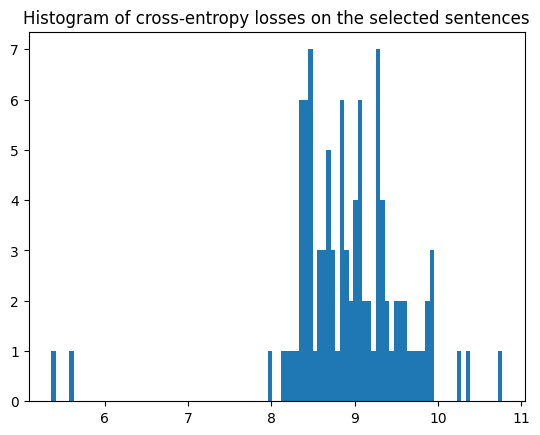

In [41]:
ce_losses = np.array(ce_losses)
plt.hist(ce_losses, bins=100)
plt.title("Histogram of cross-entropy losses on the selected sentences")
plt.show()

In [42]:
# filter adjectives, input_ids, attention_mask, and labels 
# using the low_loss_mask
adjectives_filtered = adjectives
# input_ids['input_ids'] = input_ids['input_ids'][low_loss_mask]
# input_ids['attention_mask'] = input_ids['attention_mask'][low_loss_mask]
# input_ids['labels'] = input_ids['labels'][low_loss_mask]

print(f"Length of adjectives: {len(adjectives_filtered)}")

Length of adjectives: 100


In [43]:
def get_bob_vals(past_kvs): 
    """
    Args: 
        `past_kvs`: model output['past_key_values'] from running a batch of 
        left-padded sentences through the model.

        Accepts `past_kvs`, a tuple of length NUM_LAYERS (32), each containing a 
        2-long tuple (for keys and values respectively), each containing a torch 
        Tensor of shape [batch, num_heads, seq_len, head_dim] (for values). 

    Returns: 
        `bob_kvs`: list of length BATCH_SIZE with some numpy arrays representing 
        of shape [num_layers, num_heads, head_dim]
    """

    # iterate thru batch size 
    BATCH_SIZE = past_kvs[0][1].shape[0]

    batch_bob_values = []
    for batch_el in range(BATCH_SIZE): 
        # aggregate representations from across the layers 
        bob_numpy_arrays = []
        for layer in range(len(past_kvs)): 
            bob_layer_l_value = past_kvs[layer][1][batch_el, :, -1, :].detach().cpu().numpy()
            # print("Bob layer_l_value shape: ", bob_layer_l_value.shape)

            # unsqueeze on dimension zero
            bob_numpy_arrays.append(bob_layer_l_value[np.newaxis, ...])
        
        # merge on axis 0
        bob_numpy_arrays_conc = np.concatenate(bob_numpy_arrays, axis=0)
        # print("Bob numpy arrays shape (post-concatenation to combine layers)", bob_numpy_arrays_conc.shape)
        # bob_numpy_arrays now has shape n_layers = 32, n_heads = 8, embed_dim=128

        # add it to the list
        batch_bob_values.append(bob_numpy_arrays_conc)


    return batch_bob_values


In [44]:
# iterate thru input_ids
BATCH_SIZE = 1

past_values_bob = [] # list of length NUM_ADJECTIVES, each element is
                     # a numpy array of bob value reps of shape [num_layers=32, n_heads=8, embed_dim=128]

losses = []

print("Generating Bob representations...")
# pbar = tqdm(total=len(input_ids["input_ids"]) // BATCH_SIZE + 1)
pbar = tqdm(range(len(input_ids["input_ids"]) // BATCH_SIZE))
for i in pbar:
    batch_ids = input_ids["input_ids"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)
    batch_attn = input_ids["attention_mask"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)[:, :]
    batch_labels = input_ids["labels"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)
    # print("Batch ids shape (batch, ): ", batch_ids.shape)
    # print("Input string: ", tokenizer.decode(batch_ids[15, :]))
    # print(f"Final token: `{tokenizer.decode(batch_ids[0, -1:])}`")
    outputs = model.forward(batch_ids, return_dict=True, labels=batch_labels, attention_mask=batch_attn)
    # print("Output keys: ", outputs.keys())

    past_kvs = outputs['past_key_values']

    # print("Past key values (n_layers): ", len(past_kvs))
    # print("Batch size (reconstructed): ", past_kvs[0][1].shape[0])
    bob_numpy_arrays = get_bob_vals(past_kvs) # [batch_size], each a numpy array of shape [num_layers=32, n_heads=8, embed_dim=128]

    # let's add this to the past_values_bob 
    past_values_bob += bob_numpy_arrays


    # storing the loss value
    loss = outputs['loss'].detach().cpu().numpy()
    losses.append(loss)

    # update with loss value
    pbar.set_postfix({"loss": loss})

Generating Bob representations...


100%|██████████| 100/100 [00:01<00:00, 95.12it/s, loss=9.352498]


In [45]:
tokenizer.batch_decode(input_ids['input_ids'][1:10, :])

['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>This wine has notes of banana, so the wine',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>This wine has notes of orange, so the wine',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>This wine has notes of mango, so the wine',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>This wine has notes of strawberry, so the wine',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>This wine has notes of pineapple, so the wine',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|>This wine has notes of papaya, so the wine',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|>This wine has notes of watermelon, so the wine',
 '<|endoftext|><|endoftext|>This wine has notes of cantaloupe, so the wine',
 '<|endoftext|>This wine has notes of honeydew melon, so the wine']

In [46]:
print("Number of bob representations: ", len(past_values_bob))
print("Number of adjectives: ", len(adjectives))
print("Shape of individual bob value representation: ", past_values_bob[0].shape)
print("\t[num_layers=32, n_heads=8, embed_dim=128]")
print("Length of losses: ", len(losses))
print("Loss[0]: ", losses[0])

Number of bob representations:  100
Number of adjectives:  100
Shape of individual bob value representation:  (12, 12, 64)
	[num_layers=32, n_heads=8, embed_dim=128]
Length of losses:  100
Loss[0]:  8.424513


In [47]:
print("Len of past_values_bob: ", len(past_values_bob))
print("Shape of past_values_bob[0]: ", past_values_bob[0].shape)
print("Length of losses: ", len(losses))

Len of past_values_bob:  100
Shape of past_values_bob[0]:  (12, 12, 64)
Length of losses:  100


## PCA on Bob Representations

Gotta flatten the past_values_bob[i] value reps, make a big ole matrix, and do 
PCA on it, and hope my computer doesn't explode. 

In [48]:
flat_past_values_bob = []
NUM_LAYERS = 5 # take reps from the first NUM_LAYERS layers

for i in range(len(past_values_bob)): 
    flat_past_values_bob.append(past_values_bob[i][:, :, :].flatten())

past_values_bob_matrix = np.array(flat_past_values_bob)
print("Past values bob matrix shape (num_adjectives, token_value_dim): ", past_values_bob_matrix.shape)

# save to disk 
np.save("bob_representations_flat.npy", past_values_bob_matrix)

Past values bob matrix shape (num_adjectives, token_value_dim):  (100, 9216)


In [49]:
losses_filtered = losses
past_values_bob_matrix_filtered = past_values_bob_matrix

In [50]:
# normalize each bob representation (by row)
past_values_bob_matrix_filtered_normalized = past_values_bob_matrix_filtered / np.linalg.norm(past_values_bob_matrix_filtered, axis=1)[:, np.newaxis]

np.linalg.norm(past_values_bob_matrix_filtered_normalized[0, :])

1.0

In [51]:
adjectives_filtered[:10]

['apple',
 'banana',
 'orange',
 'mango',
 'strawberry',
 'pineapple',
 'papaya',
 'watermelon',
 'cantaloupe',
 'honeydew melon']

In [52]:
# doing pca 
# Initialize PCA to keep the first 3 principal components
pca = PCA(n_components=3)

# Fit PCA on your data and transform it to get the 3-dimensional representation
transformed_data = pca.fit_transform(past_values_bob_matrix_filtered_normalized)

# transformed_data now has shape [N, 3], where N is the number of examples
print("Transformed data shape:", transformed_data.shape)
print("First 3-dimensional representation:", transformed_data[0])


Transformed data shape: (100, 3)
First 3-dimensional representation: [-0.15378188  0.00488331  0.00947171]


In [53]:
# aldo run a t-sne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(past_values_bob_matrix_filtered_normalized)

# tsne_results now has shape [N, 3], where N is the number of examples
print("TSNE results shape:", tsne_results.shape)
print("First 3-dimensional representation:", tsne_results[0])


[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] Computed neighbors for 100 samples in 0.309s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.125675
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.103325
[t-SNE] KL divergence after 300 iterations: 2.136047
TSNE results shape: (100, 3)
First 3-dimensional representation: [-23.09328    -0.9725177 -62.046276 ]


## Plotly Interactive Scatter Plot

We will output this as an HTML file you can view with the browser to explore the 
data space. 

In [54]:
import plotly.graph_objects as go

# Create a list of colors that scales with the losses 
final_losses = losses_filtered
final_data = transformed_data
final_adjectives = adjectives


colors = np.array(final_losses) - np.min(final_losses)
colors = colors / np.max(colors)


# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=final_data[:, 0],
    y=final_data[:, 1],
    z=final_data[:, 2],
    text=final_adjectives,  # Set the labels for each point
    mode='markers+text',  # Choose to have both markers and text
    marker=dict(
        size=5,
        color=colors,  # Set the color of each point
        opacity=0.8
    )
)])

# Customize the layout of the plot
fig.update_layout(
    title=f'GPT-2, Wine Fruits: PCA on <wine> reps in "This wine has hints of <adjective>. Therefore this <wine>" sentences',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Export the plot as an HTML file
fig.write_html('wine_fruits.html')

In [55]:
# scatter plot for t-sne
# Create a 3D scatter plot

final_tsne_data = tsne_results

fig = go.Figure(data=[go.Scatter3d(
    x=final_tsne_data[:, 0],
    y=final_tsne_data[:, 1],
    z=final_tsne_data[:, 2],
    text=final_adjectives,  # Set the labels for each point
    mode='markers+text',  # Choose to have both markers and text
    marker=dict(
        size=5,
        color=colors,  # Set the color of each point
        opacity=0.8
    )
)])

# Customize the layout of the plot
fig.update_layout(
    title=f'GPT-2, wine/fruits: T-SNE on <wine> reps in "This wine has notes of <fruit>, so this <wine>" sentences',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Export the plot as an HTML file
fig.write_html('wine_fruit_tsne.html')
